In [1]:
from groq import Groq
import json
import pandas as pd    
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import tqdm
import os
import numpy as np
import json
import concurrent.futures
import numpy as np
from tqdm import tqdm
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
client = Groq(api_key="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") 
api_keys=["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", "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", "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", "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"] #get multiple API keys with different Email addresses, you will run into rate limits a lot so either slow down the requests or let lots of api keys handle the job
api_keyover=0

Create DF

In [3]:
from nilmtk.dataset import DataSet
redd = DataSet('redd.h5')
building = redd.buildings[1]
main_meter = building.elec.mains()

In [4]:
dict = {'fridge' : [],
        'dish washer' : []}
appliances = ['fridge', 'dish washer']
for i in appliances:
        dict[i] = building.elec[i].power_series_all_data().to_frame(name=i)

main_df = main_meter.power_series_all_data().to_frame(name='total_power')

dict_dfs = list(dict.values())

# Concatenate all DataFrames into one
df = pd.concat([main_df] + dict_dfs, axis=1)

df = df.dropna()
df.reset_index(inplace=True)
df

Loading data for meter ElecMeterID(instance=1, building=1, dataset='REDD')     

c:\users\bhanu\nilmtk\nilmtk\utils.py:338: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  resampled = series.resample(freq).mean()
c:\users\bhanu\nilmtk\nilmtk\metergroup.py:718: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  index = pd.date_range(
c:\users\bhanu\nilmtk\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     

c:\users\bhanu\nilmtk\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))



Done loading data all meters for this chunk.


,index,total_power,fridge,dish washer
0,2011-04-18 09:22:13-04:00,341.029999,6.0,0.0
1,2011-04-18 09:22:16-04:00,342.359985,6.0,0.0
2,2011-04-18 09:22:20-04:00,342.520020,6.0,0.0
3,2011-04-18 09:22:23-04:00,342.070007,6.0,1.0
4,2011-04-18 09:22:26-04:00,341.770020,6.0,0.0
...,...,...,...,...
410090,2011-05-24 15:56:20-04:00,274.380005,186.0,1.0
410091,2011-05-24 15:56:23-04:00,273.690002,187.0,0.0
410092,2011-05-24 15:56:27-04:00,274.070007,190.0,0.0
410093,2011-05-24 15:56:30-04:00,274.750000,189.0,0.0


In [5]:
df[97254:119582]        #23rd April

,index,total_power,fridge,dish washer
97254,2011-04-23 00:00:02-04:00,172.250000,7.0,0.0
97255,2011-04-23 00:00:05-04:00,175.300003,7.0,0.0
97256,2011-04-23 00:00:09-04:00,175.250000,7.0,0.0
97257,2011-04-23 00:00:12-04:00,173.089996,6.0,0.0
97258,2011-04-23 00:00:16-04:00,173.270004,7.0,0.0
...,...,...,...,...
119577,2011-04-23 23:59:36-04:00,854.840027,7.0,0.0
119578,2011-04-23 23:59:45-04:00,851.169983,7.0,0.0
119579,2011-04-23 23:59:48-04:00,850.109985,7.0,0.0
119580,2011-04-23 23:59:52-04:00,853.880005,7.0,0.0


In [6]:
start_time = 97254 
end_time = 119582

subset_df = df.iloc[start_time:end_time].reset_index(drop=True)
fridge_power = subset_df['fridge'].to_numpy()
dish_washer = subset_df['dish washer'].to_numpy()
time = np.arange(start_time, end_time)
subset_df

,index,total_power,fridge,dish washer
0,2011-04-23 00:00:02-04:00,172.250000,7.0,0.0
1,2011-04-23 00:00:05-04:00,175.300003,7.0,0.0
2,2011-04-23 00:00:09-04:00,175.250000,7.0,0.0
3,2011-04-23 00:00:12-04:00,173.089996,6.0,0.0
4,2011-04-23 00:00:16-04:00,173.270004,7.0,0.0
...,...,...,...,...
22323,2011-04-23 23:59:36-04:00,854.840027,7.0,0.0
22324,2011-04-23 23:59:45-04:00,851.169983,7.0,0.0
22325,2011-04-23 23:59:48-04:00,850.109985,7.0,0.0
22326,2011-04-23 23:59:52-04:00,853.880005,7.0,0.0


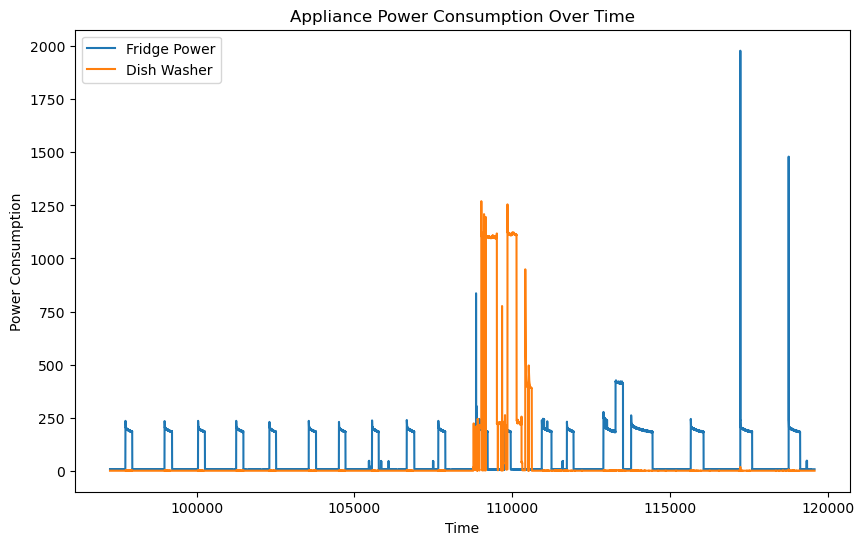

In [7]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, fridge_power, label='Fridge Power')
plt.plot(time, dish_washer, label='Dish Washer')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Power Consumption')
plt.title('Appliance Power Consumption Over Time')
plt.legend()

# Show the plot
plt.show()

In [24]:
series = pd.Series(subset_df['index'])

# Function to extract HH:MM
def extract_time(datetime_str):
    return pd.to_datetime(datetime_str).strftime('%H:%M')

# Apply the function to the Series
time_series = series.apply(extract_time)

subset_df['timestamp'] = time_series
result_df = subset_df.groupby('timestamp', as_index=False).mean()
result_df

,timestamp,index,total_power,fridge,dish washer
0,00:00,2011-04-23 00:00:29.624999936-04:00,174.016876,6.687500,0.0
1,00:01,2011-04-23 00:01:28.466666496-04:00,172.836670,6.866667,0.0
2,00:02,2011-04-23 00:02:27.500000-04:00,170.530624,6.750000,0.0
3,00:03,2011-04-23 00:03:27.812499968-04:00,171.766876,6.937500,0.0
4,00:04,2011-04-23 00:04:28.812499968-04:00,171.401871,6.812500,0.0
...,...,...,...,...,...
1435,23:55,2011-04-23 23:55:27.124999936-04:00,845.735596,7.000000,0.0
1436,23:56,2011-04-23 23:56:27.687500032-04:00,849.969360,7.000000,0.0
1437,23:57,2011-04-23 23:57:28.500000-04:00,850.686890,7.000000,0.0
1438,23:58,2011-04-23 23:58:28.812499968-04:00,853.774414,7.000000,0.0


Zeroshots

In [25]:
i = 0
# Mock function to simulate API calls
def promptgroq(csv, start_idx, chunksize, model, num_samples):
    global appliances
    answers = {'timestamps': [], 'app_predictions': {}}
    for app in appliances:
        answers['app_predictions'][app] = []
    attempts = 40
    predictions = []
    global api_keyover, client, i

    def get_prediction(run, csv=csv, start_idx=start_idx, chunksize=chunksize, model=model):
        global i, api_keyover, client
        while i < attempts:
            try:
                completion = client.chat.completions.create(
                    model='llama3-8b-8192',
                    messages=[
                        {
                            "role": "system",
                            "content": """You are a helpful assistant that performs time series predictions for NILM (Non-Intrusive Load Monitoring). The user will provide an aggregate data sequence of power consumption and timestamps, and you will predict the power consumption of the fridge and dish washer. The sequence is represented by decimal strings separated by commas for power values and HH:MM format for timestamps.
                                    Fridge consumes a low amount of the agregate power. dish washer consumes a high amount of the agregate power but it is not used as frequently as fridge so predict accordingly.
                                    Also keep in mind the other appliances.
                                    Appliance Information:
                                    Low power consuming appliances - Lighting, Electronics, Fridge
                                    Moderate power consuming appliances - Bathroom GFI, Dishwasher, Microwave, Kitchen Outlets
                                    High power consuming appliances -  Washer Dryer   
                                    USE EXACT SAME TIMESTAMPS AS IN THE GIVEN IN DATA.
                            """
                        },
                        {
                            "role": "user",
                            "content": f"""Predict the fridge power and dish washer consumption for the given time series data for the next {chunksize} timestamps. Each timestamp in the input should have a corresponding output. Return your reply in the following format:
                                            [timestamp 0, fridge prediction 0, dish washer prediction 0, timestamp 1, fridge prediction 1, dish washer prediction 1, ... timestamp {chunksize - 1}, fridge prediction {chunksize - 1}, dish washer prediction {chunksize - 1}] - the total length should be exactly {chunksize * 3}, starting from timestamp {start_idx} until the timestamp {start_idx + chunksize - 1}. Do not include any additional text or explanations.                                            
                                            ### Time Series Data
                                            {csv}
                                            """
                        }
                    ],
                    temperature=1,
                    top_p=1,
                    stream=False,
                    stop=None,
                )
            except Exception as e:
                print('API key limit reached', e)
                api_keyover += 1
                client = Groq(api_key=api_keys[api_keyover % 4])
                continue

            try:
                answer = completion.choices[0].message.content.strip()
                predictions_list = [item.strip() for item in answer.split(',') if item.strip()]

                pred_dict_app = {}
                
                pred_timestamps = predictions_list[0::len(appliances)+1]
                for i, app in enumerate(appliances):
                    pred_dict_app[app] = predictions_list[i+1::len(appliances)+1]

                pred_cleaned = {} 
                for app in appliances:
                    pred_values_cleaned = []
                    for value in pred_dict_app[app]:
                        try:
                            pred_values_cleaned.append(float(value))
                        except ValueError:
                            float_part = ''.join([char for char in value if char.isdigit() or char == '.' or char == '-'])
                            pred_values_cleaned.append(float(float_part))
                    pred_cleaned[app] = pred_values_cleaned
                
                # pred_df = pd.DataFrame({
                #     'timestamp': [ts.strip() for ts in pred_timestamps],
                #     'predicted_power': pred_cleaned
                # })
                
                pred_df = pd.DataFrame({
                    'timestamp': [ts.strip() for ts in pred_timestamps]
                })

                for appliance, predictions in pred_cleaned.items():
                    pred_df[appliance] = predictions

                if len(pred_timestamps) == chunksize:
                    return pred_df
                else:
                    i += 1
            except Exception as e:
                i += 1
                continue

        return None

    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_run = {executor.submit(get_prediction, run): run for run in range(num_samples)}
        for future in tqdm(concurrent.futures.as_completed(future_to_run)):
            result = future.result()
            if result is not None:
                predictions.append(result)

    if len(predictions) < num_samples:
        return promptgroq(csv, start_idx, chunksize, model, num_samples)

    for i in range(chunksize):
        for app in appliances:
            sum = 0
            for j in range(num_samples):
                sum += predictions[j][app][i]
            answers['app_predictions'][app].append(sum / num_samples)
        answers['timestamps'].append(predictions[0]['timestamp'][i])
        
    return answers


In [26]:
combinationstorun=[[0,15]]
model = 'llama3-70b-8192'
pred_df_list = []
# Run the loop
for start_idx, chunksize in combinationstorun:
    for start in tqdm(range(0, len(result_df) - (start_idx + chunksize), 15)):
        current_chunk = result_df.iloc[start:start+start_idx+chunksize]
        input_string = current_chunk[['timestamp', 'total_power']].to_csv(index=False, header=False)
        input_string = input_string.replace(" ", "").replace('\n', ',').replace(',', ' , ')
        answer = promptgroq(input_string, start + start_idx, chunksize, model, num_samples=2)
        predictions = answer['app_predictions']
        timestamps = answer['timestamps']
        predicted_df = pd.DataFrame({'Timestamp': timestamps})
        for appliance, predictions in predictions.items():
            predicted_df[appliance] = predictions
        print(predicted_df)
        pred_df_list.append(predicted_df)

2it [00:01,  1.34it/s][00:00<?, ?it/s]
  1%|          | 1/95 [00:01<02:23,  1.53s/it]

   Timestamp    fridge  dish washer
0     [00:00  5.058440          7.5
1      00:01  4.968335         62.5
2      00:02  4.315310         57.5
3      00:03  4.933440         52.5
4      00:04  4.750935         62.5
5      00:05  4.266875         57.5
6      00:06  4.321875         62.5
7      00:07  5.188665         67.5
8      00:08  4.906250         62.5
9      00:09  4.508435         57.5
10     00:10  4.054685         52.5
11     00:11  5.113750         67.5
12     00:12  4.831660         62.5
13     00:13  4.218120         52.5
14     00:14  4.132185         57.5


2it [00:02,  1.33s/it]
  2%|▏         | 2/95 [00:04<03:26,  2.22s/it]

   Timestamp    fridge  dish washer
0     [00:15  1.857145     5.287140
1      00:16  1.765665     5.005955
2      00:17  1.721620     4.872710
3      00:18  1.775935     5.190465
4      00:19  1.932210     5.454110
5      00:20  1.888235     4.855015
6      00:21  1.794760     5.042065
7      00:22  1.753605     4.892945
8      00:23  1.959845     5.896460
9      00:24  1.916130     5.347060
10     00:25  1.873705     5.200595
11     00:26  1.876795     5.403130
12     00:27  2.434675     6.848965
13     00:28  2.542535     7.199855
14     00:29  2.499715     6.903010


2it [00:01,  1.79it/s]
  3%|▎         | 3/95 [00:05<02:39,  1.74s/it]

   Timestamp    fridge  dish washer
0         30  32.39465    170.06170
1         31  29.89465    162.56170
2         32  28.39465    162.56170
3         33  28.55345    155.10685
4         34  28.39465    162.56170
5         35  28.55345    155.10685
6         36  27.89605    152.56665
7         37  27.05560    168.52235
8         38  25.75290    158.56665
9         39  26.05560    163.52235
10        40  24.60995    175.10685
11        41  23.95250    172.57755
12        42  24.60995    175.10685
13        43  22.95250    182.52295
14        44  22.30770    127.57755


2it [00:02,  1.31s/it]
  4%|▍         | 4/95 [00:08<03:10,  2.10s/it]

   Timestamp    fridge  dish washer
0     [00:45  1.611725      3.58945
1      00:46  1.667250      3.58905
2      00:47  1.611700      3.58910
3      00:48  1.666050      3.58915
4      00:49  1.612250      3.58920
5      00:50  1.667800      3.58925
6      00:51  1.612350      3.58930
7      00:52  1.666600      3.58935
8      00:53  1.612550      3.58940
9      00:54  1.667100      3.58945
10     00:55  1.613150      4.08950
11     00:56  1.668700      4.08955
12     00:57  1.613750      4.08960
13     00:58  1.668350      4.08965
14     00:59  1.614400      4.08970


2it [00:01,  1.89it/s]
  5%|▌         | 5/95 [00:09<02:36,  1.74s/it]

   Timestamp  fridge  dish washer
0     [60.00     1.5        25.75
1      61.00     1.5        25.75
2      62.00     1.5        25.75
3      63.00     1.5        25.75
4      64.00     1.5        25.75
5      65.00     1.5        25.75
6      66.00     1.5        25.75
7      67.00     1.5        25.75
8      68.00     1.5        25.75
9      69.00     1.5        25.75
10     70.00     1.5        25.75
11     71.00     1.5        25.75
12     72.00     1.5        25.75
13     73.00     1.5        25.75
14     74.00     1.5        25.75


2it [00:04,  2.49s/it]
  6%|▋         | 6/95 [00:14<04:13,  2.85s/it]

   Timestamp  fridge  dish washer
0         75  15.270         1.85
1         76  15.270         1.85
2         77  15.120         1.90
3         78  14.770         2.05
4         79  15.120         1.90
5         80  15.270         1.85
6         81  15.270         1.85
7         82  15.135         3.49
8         83  15.120         1.90
9         84  14.770         2.05
10        85  14.320         2.20
11        86  14.770         2.05
12        87  14.770         2.05
13        88  15.120         1.90
14        89  15.120         1.90


2it [00:03,  1.74s/it]
  7%|▋         | 7/95 [00:17<04:29,  3.07s/it]

   Timestamp     fridge  dish washer
0        [90  74.426665    61.838615
1         91  73.697220    61.830555
2         92  73.917780    62.532280
3         93  72.743335    62.997995
4         94  72.663890    63.580555
5         95  71.424445    64.055625
6         96  70.922780    64.490760
7         97  71.443890    65.004740
8         98  70.304995    65.741250
9         99  70.206110    66.532380
10       100  69.447725    67.138350
11       101  69.298335    67.956665
12       102  68.453890    68.620000
13       103  68.299505    69.373395
14       104  68.109545    70.286670


2it [00:21, 10.85s/it]
  8%|▊         | 8/95 [00:39<13:03,  9.01s/it]

   Timestamp  fridge  dish washer
0       [105  11.865      126.355
1        106  11.875      126.715
2        107  11.885      126.995
3        108  11.895      127.255
4        109  11.905      127.495
5        110  11.915      127.715
6        111  11.925      127.965
7        112  11.935      128.225
8        113  11.945      128.475
9        114  11.955      128.725
10       115  11.965      128.975
11       116  11.975      129.235
12       117  11.985      129.490
13       118  11.995      129.750
14       119  12.005      130.010


2it [00:07,  3.95s/it]
  9%|▉         | 9/95 [00:47<12:25,  8.67s/it]

    Timestamp  fridge  dish washer
0   [120:00.0   15.70        0.300
1    120:01.0   15.71        0.365
2    120:02.0   15.69        0.290
3    120:03.0   15.71        0.355
4    120:04.0    8.23       60.280
5    120:05.0    3.20       75.270
6    120:06.0    3.44       75.260
7    120:07.0    3.71       75.290
8    120:08.0    3.47       70.295
9    120:09.0    3.98       70.300
10   120:10.0    2.96       70.285
11   120:11.0    3.20       70.305
12   120:12.0    2.69       65.315
13   120:13.0    2.96       65.325
14   120:14.0    2.72       65.310


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.98s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.97s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.989s. Visit http

2it [01:51, 55.78s/it]
 11%|█         | 10/95 [02:38<57:17, 40.44s/it]

   Timestamp     fridge  dish washer
0        135  12.196250    51.125000
1        136  12.196250    49.375000
2        137  12.196650    48.750000
3        138  12.195000    49.250000
4        139  12.201335    86.031250
5        140  12.202835    81.281250
6        141  12.204165    85.902780
7        142  12.203665    85.851250
8        143  12.201665    82.407895
9        144  12.201665    80.000000
10       145  12.201665    83.225000
11       146  12.201665    82.875000
12       147  12.201335    82.864285
13       148  12.201665    81.102175
14       149  12.201665    83.650000


2it [00:26, 13.01s/it]
 12%|█▏        | 11/95 [03:04<50:26, 36.03s/it]

   Timestamp    fridge  dish washer
0     [02:30  1.747845    40.742160
1      02:31  1.760515    41.486710
2      02:32  1.743625    40.076070
3      02:33  1.761890    40.526765
4      02:34  1.770970    40.136880
5      02:35  1.792495    40.870620
6      02:36  1.781795    39.991190
7      02:37  1.796310    40.207185
8      02:38  1.815170    40.956200
9      02:39  1.802280    40.641065
10     02:40  1.826945    40.151780
11     02:41  1.837980    40.705985
12     02:42  1.833955    40.062905
13     02:43  1.867055    41.402100
14     02:44  1.877070    40.191300


2it [00:14,  7.27s/it]
 13%|█▎        | 12/95 [03:19<40:48, 29.51s/it]

   Timestamp      fridge  dish washer
0     [02:45   14.553370   195.428440
1      02:46   15.044875   196.675705
2      02:47   15.042925   196.557210
3      02:48   15.094340   196.170655
4      02:49   15.054695   196.598025
5      02:50   15.457575   202.448260
6      02:51   15.695140   202.734425
7      02:52   15.667605   202.450475
8      02:53   15.689895   202.742210
9      02:54   15.919570   203.048195
10     02:55   16.055480   203.415310
11     02:56  313.320010   383.032520
12     02:57  362.075245   402.739810
13     02:58  365.000605   397.071575
14     02:59  363.974470   395.141695


2it [00:08,  4.20s/it]
 14%|█▎        | 13/95 [03:27<31:36, 23.13s/it]

    Timestamp  fridge  dish washer
0   [180:03.0  16.690       34.210
1    181:03.0  16.660       34.135
2    182:03.0  16.630       34.155
3    183:03.0  16.465       33.920
4    184:03.0  16.395       33.865
5    185:03.0  16.320       33.795
6    186:03.0  16.255       33.730
7    187:03.0  16.215       33.695
8    188:03.0  16.190       38.670
9    189:03.0  16.170       38.655
10   190:03.0  16.140       38.625
11   191:03.0  16.115       38.600
12   192:03.0  16.105       38.585
13   193:03.0  16.095       38.575
14   194:03.0  16.080       38.560


2it [00:20, 10.39s/it]
 15%|█▍        | 14/95 [03:48<30:16, 22.43s/it]

   Timestamp  fridge  dish washer
0        195   0.075        0.005
1        196   0.075        0.005
2        197   0.075        0.005
3        198   0.075        0.005
4        199   0.075        0.005
5        200   0.075        0.005
6        201   7.575        0.005
7        202   7.575        0.005
8        203   7.575        0.005
9        204   7.575        0.005
10       205   7.575        0.005
11       206   0.075        0.005
12       207   0.075        0.005
13       208   0.075        0.005
14       209   0.075        0.005


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.776s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:24, 12.40s/it]
 16%|█▌        | 15/95 [04:13<30:52, 23.15s/it]

   Timestamp    fridge  dish washer
0     [03:30  7.203535    10.672445
1      03:31  7.115140    10.492550
2      03:32  7.220670    10.382075
3      03:33  7.073490    10.216060
4      03:34  7.279400    10.078210
5      03:35  6.981980     9.978390
6      03:36  7.238815    10.029560
7      03:37  7.142835    10.102630
8      03:38  7.250240    10.175700
9      03:39  7.105000    10.249270
10     03:40  7.308840    10.290950
11     03:41  7.115870    10.362970
12     03:42  7.267810    10.435490
13     03:43  7.022625    10.508010
14     03:44  7.275550    10.587142


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.988s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.34s/it]
 17%|█▋        | 16/95 [04:30<27:55, 21.21s/it]

   Timestamp  fridge  dish washer
0     [03:45  0.6275        3.375
1      03:46  0.6300        5.250
2      03:47  0.6300        5.250
3      03:48  0.6300        3.250
4      03:49  0.6300        3.250
5      03:50  0.6300        3.250
6      03:51  0.6100        3.300
7      03:52  0.6050        3.200
8      03:53  0.6050        3.150
9      03:54  0.6100        5.100
10     03:55  0.6150        5.250
11     03:56  0.6050        3.200
12     03:57  0.6050        3.250
13     03:58  0.6100        3.300
14     03:59  0.6200        3.350


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.989s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:24, 12.47s/it]
 18%|█▊        | 17/95 [04:55<29:02, 22.34s/it]

   Timestamp    fridge  dish washer
0     [04:00  85.31065     11.61945
1      04:01  85.51070     11.56925
2      04:02  85.61070     11.56950
3      04:03  85.71075     11.57030
4      04:04  85.81070     11.57110
5      04:05  85.66070     11.57195
6      04:06  85.61070     11.57325
7      04:07  85.71075     11.57455
8      04:08  85.81070     11.57635
9      04:09  85.61070     11.57820
10     04:10  85.71075     11.58005
11     04:11  85.81070     11.58200
12     04:12  85.61070    178.08435
13     04:13  85.71075    178.08675
14     04:14  85.81070    178.08910


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.233s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:58, 29.20s/it]
 19%|█▉        | 18/95 [05:53<42:35, 33.18s/it]

   Timestamp   fridge  dish washer
0     [04:15    0.755    32.250000
1      04:16    1.055    36.900000
2      04:17    1.120   114.436560
3      04:18    0.920   113.623960
4      04:19    0.820   112.812500
5      04:20    0.720   112.043750
6      04:21    0.670   111.264600
7      04:22    0.620   110.544900
8      04:23    0.570   109.876800
9      04:24    0.470   109.261200
10     04:25    0.420   108.749600
11     04:26    0.370   108.440600
12     04:27  186.575   107.544065
13     04:28  173.625   110.362500
14     04:29  175.100   110.955000


2it [00:05,  2.64s/it]
 20%|██        | 19/95 [05:59<31:25, 24.81s/it]

   Timestamp  fridge  dish washer
0       [270   2.855     133.4075
1        271   2.855     133.3725
2        272   2.965     133.6625
3        273   2.885     133.3825
4        274   3.005     133.9275
5        275   2.945     133.6475
6        276   2.895     118.6060
7        277   2.980     118.9060
8        278   2.920     126.1380
9        279   2.965     132.9205
10       280   2.960     121.6545
11       281   2.955     121.7345
12       282   2.925     125.7990
13       283   2.995     131.1305
14       284   2.975     119.5725


2it [00:05,  2.60s/it]
 21%|██        | 20/95 [06:04<23:39, 18.93s/it]

   Timestamp   fridge  dish washer
0      04:45   61.800       28.450
1      04:46   62.100       28.550
2      04:47   61.950       28.350
3      04:48   62.300       28.650
4      04:49   61.850       28.450
5      04:50  148.110      115.660
6      04:51  148.415      115.390
7      04:52  147.895      115.190
8      04:53  148.270      115.675
9      04:54  148.590      116.015
10     04:55  148.195      115.230
11     04:56  148.440      115.790
12     04:57  148.320      115.510
13     04:58  148.630      116.120
14     04:59  148.490      115.780


2it [00:07,  3.66s/it]
 22%|██▏       | 21/95 [06:11<19:03, 15.45s/it]

   Timestamp  fridge  dish washer
0        300   0.275         0.05
1        301   0.275         0.05
2        302   0.275         0.05
3        303   0.275         0.05
4        304   0.270         0.55
5        305   0.270         0.55
6        306   0.270         0.55
7        307   0.270         0.05
8        308   0.270         0.05
9        309   0.270         0.05
10       310   0.270         0.55
11       311   0.270         0.55
12       312   0.270         0.55
13       313   0.270         0.05
14       314   0.270         0.05


2it [00:08,  4.09s/it]
 23%|██▎       | 22/95 [06:19<16:09, 13.28s/it]

   Timestamp    fridge  dish washer
0     [05:30  5.861725    50.339450
1      05:31  5.861750    50.339425
2      05:32  5.861775    50.339450
3      05:33  5.861800    50.339500
4      05:34  5.861825    55.339450
5      05:35  5.861850    70.639450
6      05:36  5.861875    70.639550
7      05:37  5.861900    70.639600
8      05:38  5.861925    70.639650
9      05:39  5.861950    70.639700
10     05:40  5.861975    73.139450
11     05:41  5.862000    74.139450
12     05:42  5.862025    74.639450
13     05:43  5.862050    80.639550
14     05:44  5.862075    80.639600


2it [41:57, 1258.55s/it]
 24%|██▍       | 23/95 [48:16<15:17:34, 764.64s/it]

   Timestamp  fridge  dish washer
0       [330  23.020      135.380
1        331  23.165      135.575
2        332  23.855      136.345
3        333  22.930      135.705
4        334  22.725      135.375
5        335  22.185      133.740
6        336  22.915      135.325
7        337  22.295      133.930
8        338  21.915      133.445
9        339  21.470      132.320
10       340  22.385      133.830
11       341  21.990      133.180
12       342  22.025      133.710
13       343  22.280      134.325
14       344  21.610      132.825


2it [00:01,  1.63it/s]
 25%|██▌       | 24/95 [48:18<10:33:46, 535.59s/it]

   Timestamp    fridge  dish washer
0        359  50.17255       2.5005
1        358  50.35960       0.2510
2        357  50.00580       0.6515
3        356  50.26070       0.3005
4        355  49.95580       0.5515
5        354  50.21070       0.3510
6        353  49.92255       0.7005
7        352  50.20960       0.2515
8        351  50.00580       0.8010
9        350  50.06070       0.4005
10       349  50.12255       0.9015
11       348  50.05960       0.4510
12       347  50.15580       1.0005
13       346  49.96070       0.5515
14       345  50.12255       1.1005


2it [00:05,  2.63s/it]
 26%|██▋       | 25/95 [48:23<7:19:14, 376.49s/it] 

   Timestamp  fridge  dish washer
0       [360   0.035        5.020
1        361   0.035        5.020
2        362   0.035        5.010
3        363   0.035        5.010
4        364   0.030        5.005
5        365   0.030        5.005
6        366   0.035        5.015
7        367   0.035        5.015
8        368   0.030        5.005
9        369   0.030        5.010
10       370   0.030        5.010
11       371   0.035        5.010
12       372   0.030        5.005
13       373   0.030        5.005
14       374   0.035        5.010


2it [00:01,  1.83it/s]
 27%|██▋       | 26/95 [48:24<5:03:27, 263.88s/it]

   Timestamp  fridge  dish washer
0        375  12.945       30.445
1        376  12.695       50.875
2        377  12.695       51.375
3        378  12.695       51.625
4        379  12.445       51.875
5        380  12.445       51.750
6        381  12.695       52.000
7        382  12.790       52.655
8        383  12.540       52.905
9        384  13.040       53.405
10       385  13.040       53.655
11       386  12.830       54.040
12       387  13.080       54.290
13       388  12.830       54.540
14       389  13.080       54.790


2it [00:04,  2.15s/it]
 28%|██▊       | 27/95 [48:29<3:30:48, 186.01s/it]

   Timestamp  fridge  dish washer
0      06:30    0.15         0.00
1      06:31    0.25         0.00
2      06:32    0.20         0.00
3      06:33    0.15         0.00
4      06:34    0.30       150.00
5      06:35    0.25       150.00
6      06:36    0.20       150.00
7      06:37    0.30       150.00
8      06:38    0.50       300.00
9      06:39    0.45       294.75
10     06:40    0.40       291.50
11     06:41    0.35       290.50
12     06:42    0.35       290.50
13     06:43    0.30       289.00
14     06:44    0.25       288.00


2it [00:01,  1.61it/s]
 29%|██▉       | 28/95 [48:30<2:25:49, 130.59s/it]

   Timestamp  fridge  dish washer
0     [06:45   0.055       0.0055
1      06:46   0.055       7.5050
2      06:47   0.055       7.5000
3      06:48   0.055       7.2500
4      06:49   0.055       7.2500
5      06:50   0.055       6.7500
6      06:51   0.055       6.1250
7      06:52   0.055       6.1250
8      06:53   0.055      61.1250
9      06:54   0.055      60.6250
10     06:55   0.055      62.3300
11     06:56   0.055      62.0050
12     06:57   0.055      61.3500
13     06:58   0.055      60.2000
14     06:59   0.055      59.6400


2it [00:11,  5.71s/it]
 31%|███       | 29/95 [48:41<1:44:19, 94.85s/it] 

   Timestamp  fridge  dish washer
0        420    3.35         5.55
1        421    3.45         6.45
2        422    3.40         5.85
3        423    3.30         6.20
4        424    3.30         6.30
5        425    3.45         5.90
6        426    3.45         6.00
7        427    3.45         5.70
8        428    3.55         5.70
9        429    3.40         5.95
10       430    3.65         6.15
11       431    3.65         5.50
12       432    3.50         6.00
13       433    3.70         5.60
14       434    3.45         6.10


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.862s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:45, 22.75s/it]
 32%|███▏      | 30/95 [49:27<1:26:43, 80.06s/it]

   Timestamp   fridge  dish washer
0       [435  34.9935      38.8730
1        436  35.2795      41.1110
2        437  35.4905      40.6780
3        438  35.1840      41.7970
4        439  35.3575      42.7215
5        440  35.6170      43.2470
6        441  34.9060      43.9160
7        442  35.2265      42.6460
8        443  35.4610      43.5190
9        444  35.6585      42.3410
10       445  35.4740      43.2305
11       446  35.3410      44.0105
12       447  35.4465      44.1485
13       448  35.5575      44.5605
14       449  35.6455      45.0900


2it [00:13,  6.53s/it]
 33%|███▎      | 31/95 [49:40<1:03:57, 59.96s/it]

   Timestamp  fridge  dish washer
0     [07:30   1.065        0.615
1      07:31   1.070       41.755
2      07:32   1.025       40.610
3      07:33   1.030       40.285
4      07:34   1.185       39.640
5      07:35   1.040       38.295
6      07:36   0.995       37.450
7      07:37   1.000       36.605
8      07:38   1.155       35.810
9      07:39   1.110       34.965
10     07:40   0.865       34.120
11     07:41   0.870       76.875
12     07:42   0.825      149.330
13     07:43   0.830      144.895
14     07:44   0.835      142.100


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.887s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:14,  7.07s/it]
 34%|███▎      | 32/95 [49:54<48:32, 46.23s/it]  

   Timestamp  fridge  dish washer
0       [465  10.525         28.1
1        466  10.525         28.1
2        467  10.525         28.1
3        468  10.525         28.1
4        469  10.525         28.1
5        470  10.525         28.1
6        471  11.025         25.6
7        472  11.025         26.1
8        473  11.025         26.6
9        474  11.025         27.6
10       475  11.525         28.6
11       476  11.525         29.1
12       477  11.525         29.6
13       478  11.525         30.1
14       479  12.025         30.6


2it [00:14,  7.20s/it]
 35%|███▍      | 33/95 [50:08<37:54, 36.69s/it]

   Timestamp  fridge  dish washer
0       [480   15.75        55.00
1        481   16.10        54.05
2        482   15.45        52.45
3        483   15.15        56.35
4        484   15.90        54.10
5        485   15.55        51.75
6        486   15.45        56.45
7        487   15.80        54.15
8        488   15.70        51.25
9        489   15.30        56.15
10       490   15.85        53.55
11       491   15.75        51.20
12       492   15.15        56.10
13       493   15.90        54.05
14       494   15.35        56.30


2it [00:05,  2.57s/it]
 36%|███▌      | 34/95 [50:14<27:41, 27.23s/it]

   Timestamp     fridge  dish washer
0       [495  49.267437        27.85
1        496  49.067453        29.15
2        497  48.767500        27.25
3        498  48.417558        25.75
4        499  48.167435        21.30
5        500  47.917516        20.60
6        501  47.767468        19.45
7        502  47.617573        18.30
8        503  47.467626        17.15
9        504  47.300000        18.50
10       505  47.167680        17.85
11       506  47.067478        17.20
12       507  46.967734        16.55
13       508  46.867787        15.90
14       509  46.767840        15.25


2it [00:08,  4.24s/it]
 37%|███▋      | 35/95 [50:22<21:37, 21.62s/it]

   Timestamp  fridge  dish washer
0     [08:30    0.10         0.00
1      08:31    0.10         0.00
2      08:32    0.10         0.00
3      08:33    5.55        70.15
4      08:34   50.55        70.15
5      08:35   50.55        70.15
6      08:36   50.55        70.15
7      08:37   50.55        70.15
8      08:38   50.55        70.15
9      08:39   75.55        70.15
10     08:40  100.55        70.15
11     08:41  100.55        70.15
12     08:42  500.55      1070.15
13     08:43  500.55      1070.15
14     08:44  750.55      1070.15


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.934s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.13s/it]
 38%|███▊      | 36/95 [50:38<19:41, 20.02s/it]

   Timestamp     fridge  dish washer
0       [525  82.123425   564.790090
1        526  81.845630   553.012290
2        527  81.567385   552.067845
3        528  80.293340   548.450550
4        529  79.519595   544.850555
5        530  78.756200   540.295760
6        531  77.992355   535.695965
7        532  77.224510   530.645820
8        533  76.461665   526.095675
9        534  75.248820   521.545530
10       535  74.540975   516.995485
11       536  73.833130   512.445640
12       537  73.125335   507.895795
13       538  72.417490   503.346000
14       539  71.709645   498.795705


2it [00:05,  2.59s/it]
 39%|███▉      | 37/95 [50:44<15:03, 15.58s/it]

   Timestamp  fridge  dish washer
0       [540    1.85        25.40
1        541    1.85        25.25
2        542    1.85        25.55
3        543   32.10       525.15
4        544    1.85        26.45
5        545    1.85        24.80
6        546    1.85        25.15
7        547   32.10       525.75
8        548    1.85        25.15
9        549    1.85        26.35
10       550    1.85        25.55
11       551   32.10       525.30
12       552    1.90        27.25
13       553    1.90        27.05
14       554    1.90        27.15


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.997s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.886s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:25, 12.85s/it]
 40%|████      | 38/95 [51:09<17:41, 18.62s/it]

   Timestamp     fridge  dish washer
0       [555  53.972790     3.661120
1        556  53.933570     6.274560
2        557  53.903215     6.675880
3        558  53.873170     6.067755
4        559  53.843460     5.965130
5        560  53.814015     6.241585
6        561  53.784795     6.020315
7        562  53.755710     6.296375
8        563  53.726915     6.573945
9        564  53.698345     6.807155
10       565  53.674870     6.540875
11       566  53.646560     6.776735
12       567  53.613400     6.012470
13       568  53.585435     6.608365
14       569  53.557520     5.845140


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.95s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.56s/it]
 41%|████      | 39/95 [51:23<15:50, 16.98s/it]

   Timestamp  fridge  dish washer
0       [570  52.775       10.755
1        571  53.060       12.780
2        572  52.540       12.635
3        573  53.055       13.715
4        574  52.420       12.815
5        575  52.840       13.720
6        576  52.025       13.060
7        577  53.025       14.065
8        578  51.860       13.015
9        579  53.295       14.605
10       580  51.445       13.340
11       581  52.710       14.095
12       582  50.915       12.870
13       583  53.145       15.275
14       584  51.795       13.860


2it [00:05,  2.64s/it]
 42%|████▏     | 40/95 [51:28<12:21, 13.48s/it]

   Timestamp  fridge  dish washer
0     [09:45  11.810       80.985
1      09:46  11.865       80.805
2      09:47  11.845       79.205
3      09:48  11.850       77.850
4      09:49  11.905       77.395
5      09:50  11.935       77.140
6      09:51  11.890       75.185
7      09:52  11.895       73.930
8      09:53  11.950       73.425
9      09:54  11.955       72.270
10     09:55  11.960       71.165
11     09:56  11.965       69.960
12     09:57  11.970       69.305
13     09:58  12.000       68.550
14     09:59  11.955       66.895


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.808s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:26, 13.20s/it]
 43%|████▎     | 41/95 [51:54<15:37, 17.36s/it]

   Timestamp  fridge  dish washer
0       [600  40.290      109.765
1        601  40.015      110.800
2        602  40.235      110.060
3        603  40.190      109.665
4        604  40.095      110.205
5        605  39.830      110.930
6        606  39.680      111.085
7        607  39.995      110.285
8        608  39.665      110.715
9        609  39.820      110.095
10       610  39.775      110.495
11       611  39.730      111.055
12       612  39.865      110.655
13       613  39.640      110.845
14       614  39.595      111.480


2it [00:05,  2.59s/it]
 44%|████▍     | 42/95 [52:00<12:07, 13.72s/it]

   Timestamp  fridge  dish washer
0       [615   117.5        175.0
1        616   117.5        175.0
2        617   115.0        150.0
3        618   112.5        160.0
4        619   112.5        155.0
5        620   110.0        145.0
6        621   107.5        140.0
7        622   105.0        135.0
8        623   102.5        130.0
9        624   100.0        125.0
10       625    97.5        120.0
11       626    95.0        115.0
12       627    92.5        110.0
13       628    90.0        105.0
14       629    87.5        100.0


2it [00:16,  8.05s/it]
 45%|████▌     | 43/95 [52:16<12:31, 14.44s/it]

   Timestamp  fridge  dish washer
0        630   8.857       11.745
1        631   8.782       11.875
2        632   8.842       10.170
3        633   8.607       10.430
4        634   8.677        9.550
5        635   8.342        9.745
6        636   8.577        9.295
7        637   8.292        9.600
8        638   8.467        9.205
9        639   8.242        9.645
10       640   8.092        9.355
11       641   8.127        9.395
12       642   7.877        9.170
13       643   7.752        9.220
14       644   7.847        9.015


2it [00:11,  5.81s/it]
 46%|████▋     | 44/95 [52:27<11:33, 13.61s/it]

   Timestamp  fridge  dish washer
0        645   7.275         0.05
1        646   7.275         0.05
2        647   7.775         0.00
3        648   7.300         0.00
4        649   7.275         0.00
5        650   7.775         0.00
6        651   7.275         0.00
7        652   7.775         0.00
8        653   0.775       499.75
9        654   0.800       396.25
10       655   7.300         0.00
11       656   7.800         0.00
12       657   7.300         0.05
13       658   7.800         0.05
14       659   7.300         0.05


2it [00:05,  2.58s/it]
 47%|████▋     | 45/95 [52:32<09:14, 11.08s/it]

   Timestamp     fridge  dish washer
0        660  14.667975     10.36175
1        661  14.687460     10.26050
2        662  14.522430     10.10925
3        663  14.542330     10.05775
4        664  14.472350     10.00600
5        665  14.402270      9.90475
6        666  59.642290     47.60325
7        667  59.572310     47.25175
8        668  59.512330     47.15025
9        669  59.467360     47.10100
10       670  59.402390     47.05175
11       671  59.342410     47.00250
12       672  59.332440     46.95325
13       673  59.272460     46.90400
14       674  59.220000     46.85500


2it [00:10,  5.23s/it]
 48%|████▊     | 46/95 [52:43<08:54, 10.90s/it]

   Timestamp  fridge  dish washer
0        675    50.2          0.0
1        676    50.2          0.0
2        677    50.6         25.0
3        678    51.1         25.0
4        679    50.1         25.0
5        680    50.6         25.0
6        681    51.1         25.0
7        682    51.6         25.0
8        683    51.1         25.0
9        684    50.6         25.0
10       685    50.1         50.0
11       686    50.1         50.0
12       687     0.1        750.0
13       688    55.0        150.0
14       689    55.5        150.0


2it [00:02,  1.45s/it]
 49%|████▉     | 47/95 [52:46<06:48,  8.51s/it]

   Timestamp   fridge  dish washer
0      690.0  0.55005      1.75005
1      691.0  0.55005      1.75005
2      692.0  0.55005      1.75005
3      693.0  0.55005      1.75005
4      694.0  0.55005      1.75005
5      695.0  0.55005      1.75005
6      696.0  0.55005      1.75005
7      697.0  0.55050      1.80000
8      698.0  0.55005      1.75005
9      699.0  0.55005      1.75005
10     700.0  0.55050      1.80000
11     701.0  0.55005      1.75005
12     702.0  0.55005      1.75005
13     703.0  0.55005      1.75005
14     704.0  0.55050      1.80000


2it [00:18,  9.33s/it]
 51%|█████     | 48/95 [53:05<09:03, 11.56s/it]

   Timestamp  fridge  dish washer
0       [705  6.2725    18.033945
1        706  6.2210    17.530555
2        707  6.3220    18.331665
3        708  6.2730    17.882780
4        709  6.3750    18.233850
5        710  6.3260    18.084920
6        711  6.2770    17.836000
7        712  6.3780    18.387075
8        713  6.3290    17.988140
9        714  6.2800    17.739205
10       715  6.3810    18.540270
11       716  6.3320    18.141335
12       717  6.2830    17.942400
13       718  6.3840    18.693465
14       719  6.3350    18.044530


2it [00:05,  2.66s/it]
 52%|█████▏    | 49/95 [53:10<07:25,  9.69s/it]

   Timestamp     fridge  dish washer
0       [720  20.061725      7.83945
1        721  20.117250      7.73390
2        722  19.999500      7.61570
3        723  19.422800      7.83945
4        724  20.061700      8.30560
5        725  19.938250      8.32715
6        726  19.367250      8.39400
7        727  19.999550      7.96605
8        728  20.061700      8.55560
9        729  20.117250      7.99450
10       730  20.172800      8.47105
11       731  19.688250      7.82715
12       732  20.061700      8.35560
13       733  20.117250      8.24450
14       734  19.922800      8.27105


2it [00:11,  5.62s/it]
 53%|█████▎    | 50/95 [53:21<07:37, 10.17s/it]

   Timestamp   fridge  dish washer
0       [735  13.6725      15.0000
1        736  13.6605       8.1170
2        737  14.1500      10.6000
3        738  13.9910       8.6725
4        739  14.0615      11.0615
5        740  13.4500       6.2100
6        741  14.0100       8.5750
7        742  13.9000      11.0450
8        743  13.5500       6.0300
9        744  13.3500       6.0200
10       745  14.0150      11.0100
11       746  13.8250       8.5050
12       747  14.0200       8.5000
13       748  13.3000       5.9900
14       749  14.0250      10.9850


2it [00:05,  2.58s/it]
 54%|█████▎    | 51/95 [53:26<06:21,  8.68s/it]

   Timestamp   fridge  dish washer
0        750  64.2280     650.0615
1        751  64.7835     651.1725
2        752  65.8945     652.2835
3        753  66.9505     653.4540
4        754  67.0615     654.5005
5        755  67.7280     655.5560
6        756  68.3945     656.6605
7        757  68.9505     657.7280
8        758  69.2280     658.5445
9        759  64.7835     659.6170
10       760  65.8945     660.7280
11       761  74.4505     761.8945
12       762  67.0615     662.9505
13       763  67.7280     663.8900
14       764  68.3945     664.9995


2it [00:05,  2.60s/it]
 55%|█████▍    | 52/95 [53:32<05:28,  7.65s/it]

   Timestamp      fridge  dish washer
0        765  1222.34280    644.75570
1        766  1222.35590    640.26705
2        767  1219.47225    640.83350
3        768  1220.91665    638.87280
4        769  1233.51115    644.47060
5        770  1231.17795    644.63660
6        771  1230.44565    644.79570
7        772  1230.35740    644.95355
8        773  1230.81410    649.11090
9        774  1231.24550    649.27095
10       775  1231.69655    649.08960
11       776  1232.14765    648.90280
12       777  1232.56090    652.71430
13       778  1232.97745    652.52865
14       779  1232.86155    653.30605


2it [00:05,  2.59s/it]
 56%|█████▌    | 53/95 [53:37<04:50,  6.92s/it]

   Timestamp    fridge  dish washer
0       [780  70.37330       0.0000
1        781  71.12275       0.5500
2        782  69.41675       0.0000
3        783  72.45525       1.2500
4        784  71.34225       0.0000
5        785  73.92775       0.9000
6        786  70.96175       0.0000
7        787  73.84325       1.1000
8        788  71.77325       0.0000
9        789  73.60125       0.4500
10       790  74.22775       0.6500
11       791  73.70275       0.0000
12       792  75.57625       1.0000
13       793  73.49825       0.4000
14       794  75.16875       1.6224


2it [00:13,  6.98s/it]
 57%|█████▋    | 54/95 [53:51<06:10,  9.05s/it]

   Timestamp     fridge  dish washer
0       [795  83.724217   517.526433
1        796  82.984117   526.760333
2        797  86.293517   526.460133
3        798  85.902817   522.397883
4        799  85.397617   519.510933
5        800  84.387967   520.811533
6        801  83.778867   518.157183
7        802  83.244817   522.435033
8        803  82.737867   519.305583
9        804  82.262467   517.115183
10       805  81.813067   522.406033
11       806  81.380567   518.099933
12       807  80.971067   518.299833
13       808  80.599517   523.410833
14       809  80.269467   522.446083


2it [00:45, 22.97s/it]
 58%|█████▊    | 55/95 [54:37<13:24, 20.12s/it]

   Timestamp    fridge  dish washer
0      13:30  87.21665   1282.47280
1      13:31  84.23280   1233.46725
2      13:32  84.74805   1196.38945
3      13:33  85.83390   1180.36170
4      13:34  87.51095   1164.82280
5      13:35  89.08360   1112.33270
6      13:36  88.11770   1102.25060
7      13:37  89.97160   1085.10490
8      13:38  91.55835   1069.07280
9      13:39  90.22805   1054.69505
10     13:40  88.57305   1042.77105
11     13:41  90.66725   1034.01170
12     13:42  89.62455   1025.08390
13     13:43  14.96095    882.15060
14     13:44  11.32890    767.78270


2it [00:05,  2.64s/it]
 59%|█████▉    | 56/95 [54:42<10:11, 15.68s/it]

   Timestamp      fridge  dish washer
0       [825  161.852205     17.36340
1        826  161.515575     15.53045
2        827  159.836570     16.17015
3        828  157.814325     15.72780
4        829  158.338220     15.21790
5        830  156.894605     16.30060
6        831  154.883175     15.47365
7        832  154.014970     14.99305
8        833  154.910725     14.67645
9        834  152.734905     14.31910
10       835  150.994370     15.51925
11       836  148.727605     14.29755
12       837  149.828030     13.86610
13       838  148.109865     14.40135
14       839  145.732355     13.38945


2it [00:16,  8.14s/it]
 60%|██████    | 57/95 [54:58<10:02, 15.87s/it]

   Timestamp     fridge  dish washer
0       [840  100.63790    160.14315
1        841   98.69560    185.19090
2        842  102.37395    196.83805
3        843  101.84700    202.51510
4        844  106.10105    210.93245
5        845  104.53105    210.39090
6        846  109.90695    208.86095
7        847  109.35185    207.67265
8        848  112.18820    206.09990
9        849  111.75640    204.41775
10       850  116.56725    202.96190
11       851  116.89710    202.12265
12       852  119.95605    200.99770
13       853  119.46415    199.86080
14       854  123.11625    199.55595


2it [00:08,  4.07s/it]
 61%|██████    | 58/95 [55:07<08:21, 13.56s/it]

   Timestamp     fridge  dish washer
0       [855  82.422835   241.356170
1        856  81.857280   340.717360
2        857  83.206170   265.910780
3        858  83.243825   365.309900
4        859  83.805555   316.583300
5        860  83.671605   391.722355
6        861  85.249995   416.939455
7        862  84.026315   441.860715
8        863  82.907895   467.722860
9        864  82.421170   452.305555
10       865  82.468095   492.856725
11       866  83.071440   483.307565
12       867  83.905565   468.522835
13       868  83.644655   453.911390
14       869  84.928570   494.700610


2it [00:05,  2.73s/it]
 62%|██████▏   | 59/95 [55:12<06:41, 11.14s/it]

   Timestamp    fridge  dish washer
0        870  40.27125      0.05000
1        871  40.24625      0.05000
2        872  40.22085      0.05000
3        873  39.44585      0.75000
4        874  39.79655      0.72500
5        875  40.09655      0.65000
6        876  40.04605      0.60000
7        877  39.79605      0.57500
8        878  39.92095      0.55000
9        879  39.57095      0.52500
10       880  39.37070      0.47500
11       881  39.27070      0.45000
12       882  39.60975      3.02175
13       883  39.10885      3.67085
14       884  40.05885      3.64585


2it [00:08,  4.15s/it]
 63%|██████▎   | 60/95 [55:20<06:00, 10.31s/it]

   Timestamp      fridge  dish washer
0       [885  167.215560   817.052630
1        886  167.607955   802.572775
2        887  170.059110   822.066085
3        888  169.627505   798.675590
4        889  169.365565   806.219565
5        890  170.758605   809.550775
6        891  171.065960   804.195960
7        892  170.985565   795.695605
8        893  173.156210   802.460990
9        894  172.707555   792.755590
10       895  174.225555   800.505615
11       896  173.755615   789.760585
12       897  175.110610   797.456165
13       898  174.811225   788.676065
14       899  176.061725   797.051820


2it [00:08,  4.12s/it]
 64%|██████▍   | 61/95 [55:29<05:29,  9.69s/it]

   Timestamp  fridge  dish washer
0       [900  73.970        0.000
1        901  74.065        0.000
2        902  74.365        0.000
3        903  74.080        0.000
4        904  73.745        0.000
5        905  73.880        0.000
6        906  73.750      122.935
7        907  74.530       17.550
8        908  74.275        0.000
9        909  73.930       14.250
10       910  73.740        0.000
11       911  74.150        0.000
12       912  73.820      126.610
13       913  73.895        0.000
14       914  73.975        0.000


2it [00:05,  2.59s/it]
 65%|██████▌   | 62/95 [55:34<04:35,  8.34s/it]

   Timestamp    fridge  dish washer
0       [915  70.10770     12.60925
1        916  72.60805     11.44560
2        917  70.10715     24.56595
3        918  67.60610     18.59455
4        919  67.60520     26.75565
5        920  72.60430     22.82690
6        921  70.10340     28.42135
7        922  67.60255     19.18075
8        923  72.60170     22.06725
9        924  67.60085     21.17560
10       925  67.60005     29.05935
11       926  72.59920     19.59180
12       927  72.59835     26.25105
13       928  70.09750     15.60975
14       929  72.59665     24.82710


2it [00:05,  2.56s/it]
 66%|██████▋   | 63/95 [55:39<03:56,  7.38s/it]

   Timestamp     fridge  dish washer
0       [930  15.684955    28.007560
1        931  15.709010    24.785840
2        932  15.735100    29.287405
3        933  15.763160    26.013230
4        934  15.794175    23.295115
5        935  15.829235    27.800840
6        936  15.867790    24.531325
7        937  15.908850    21.820220
8        938  15.952410    26.331910
9        939  15.997970    22.567360
10       940  16.046030    19.360280
11       941  16.096090    23.379385
12       942  16.147950    19.618300
13       943  16.202615    16.411180
14       944  16.259825    20.475335


2it [00:08,  4.12s/it]
 67%|██████▋   | 64/95 [55:47<03:57,  7.65s/it]

   Timestamp     fridge  dish washer
0        945  40.111725    24.567250
1        946  40.711725    24.517250
2        947  40.072715    25.361750
3        948  40.789170    23.483550
4        949  39.722835    26.000715
5        950  40.183945    25.533655
6        951  39.667250    26.572835
7        952  40.328055    25.756170
8        953  39.988265    27.050715
9        954  41.045490    26.222835
10       955  40.328390    26.906170
11       956  40.822880    26.333945
12       957  40.883945    27.767250
13       958  40.995490    27.250715
14       959  41.722835    27.672880


2it [00:22, 11.42s/it]
 68%|██████▊   | 65/95 [56:10<06:06, 12.21s/it]

   Timestamp     fridge  dish washer
0       [960  18.669650     2.656635
1        961  18.658590     2.636975
2        962  18.504635     2.509770
3        963  18.611705     2.680660
4        964  18.567000     2.658335
5        965  18.449750     2.515550
6        966  18.675695     2.682060
7        967  18.470590     2.522135
8        968  18.620695     2.697235
9        969  18.511665     2.524760
10       970  18.688705     2.721925
11       971  18.515555     2.530775
12       972  18.697000     2.740615
13       973  18.527500     2.536685
14       974  18.724995     2.758415


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.942s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:08,  4.33s/it]
 69%|██████▉   | 66/95 [56:19<05:23, 11.16s/it]

   Timestamp     fridge  dish washer
0        975  27.242335   162.257665
1        976  27.270665   161.779000
2        977  27.306225   161.243775
3        978  27.340910   160.709090
4        979  27.374960   160.175040
5        980  27.408160   159.635840
6        981  27.390460   159.109540
7        982  27.422160   158.577840
8        983  27.503760   158.046240
9        984  27.534860   157.515140
10       985  27.565910   157.484090
11       986  27.596960   156.953040
12       987  27.627960   156.422400
13       988  27.658560   155.891440
14       989  27.689160   155.360840


2it [00:05,  2.95s/it]
 71%|███████   | 67/95 [56:25<04:28,  9.59s/it]

   Timestamp  fridge  dish washer
0        990  12.125         0.40
1        991  12.675         0.45
2        992  12.075         0.35
3        993  12.725         0.55
4        994  12.175         0.50
5        995  12.625         0.60
6        996  12.275         0.70
7        997  12.775         0.65
8        998  12.325         0.75
9        999  12.925         0.80
10      1000  12.475         0.85
11      1001  13.100         3.65
12      1002  12.550         2.20
13      1003  13.250         2.25
14      1004  12.700         1.80


2it [00:05,  2.58s/it]
 72%|███████▏  | 68/95 [56:30<03:43,  8.28s/it]

   Timestamp     fridge  dish washer
0       1005  115.91665   156.095666
1       1006  114.56515   157.775300
2       1007  114.84760   157.092500
3       1008  113.79760   157.775300
4       1009  113.29760   156.830100
5       1010  112.90000   157.092500
6       1011  111.54760   157.092500
7       1012  107.79760   156.872950
8       1013  105.31525   156.827550
9       1014  103.86525   156.225000
10      1015  102.81525   155.727600
11      1016  101.91525   155.654900
12      1017  100.91525   155.177100
13      1018  100.21525   155.177100
14      1019   99.31525   154.695000


2it [00:05,  2.91s/it]
 73%|███████▎  | 69/95 [56:36<03:16,  7.55s/it]

   Timestamp  fridge  dish washer
0       1020   57.50        50.00
1       1021   56.95        25.50
2       1022   56.00        50.00
3       1023   55.55        25.00
4       1024   57.25        51.00
5       1025   57.60        25.00
6       1026   58.50        50.50
7       1027   58.65        25.00
8       1028   57.00        50.75
9       1029   56.95        25.00
10      1030   56.50        50.75
11      1031   56.50        25.00
12      1032   58.25        50.75
13      1033   55.80        25.00
14      1034   57.75        50.25


2it [00:04,  2.49s/it]
 74%|███████▎  | 70/95 [56:41<02:49,  6.79s/it]

   Timestamp     fridge  dish washer
0      [1035  557.10460   1241.90095
1       1036  133.27990    182.44855
2       1037  119.24830   1181.24720
3       1038  113.26355   1183.76585
4       1039  124.93560   1173.72265
5       1040  113.62625   1202.66290
6       1041  103.51455   1188.14255
7       1042  112.80300   1181.24135
8       1043  107.95045   1176.76455
9       1044  103.07960   1176.74010
10      1045  107.76930   1181.72770
11      1046  104.58785   1171.58545
12      1047  102.43415   1181.95805
13      1048  100.85920   1175.22215
14      1049   99.18730   1177.92820


2it [00:05,  2.63s/it]
 75%|███████▍  | 71/95 [56:46<02:32,  6.34s/it]

   Timestamp  fridge  dish washer
0      [1050    7.77       23.860
1       1051    7.78       24.155
2       1052    7.84       24.375
3       1053    7.75       24.295
4       1054    7.81       24.515
5       1055    7.87       24.685
6       1056    7.78       24.655
7       1057    7.84       24.875
8       1058    7.90       25.095
9       1059    7.81       25.015
10      1060    7.87       25.235
11      1061    7.93       25.405
12      1062    7.84       25.375
13      1063    7.90       25.595
14      1064    7.96       25.815


2it [00:05,  2.62s/it]
 76%|███████▌  | 72/95 [56:51<02:18,  6.02s/it]

   Timestamp      fridge  dish washer
0       1065  129.462425    241.41605
1       1066  129.389200    244.00600
2       1067  128.711050    242.61125
3       1068  128.137950    242.06250
4       1069  127.714750    241.75625
5       1070  127.141450    241.63975
6       1071  126.568150    241.67000
7       1072  125.945900    241.15080
8       1073  125.423550    241.13150
9       1074  124.851500    241.11230
10      1075  124.379400    241.04310
11      1076  123.807100    240.97430
12      1077  123.235300    240.65550
13      1078  122.713550    240.63670
14      1079  122.141800    240.56840


2it [00:05,  2.55s/it]
 77%|███████▋  | 73/95 [56:57<02:06,  5.76s/it]

   Timestamp  fridge  dish washer
0      [1080   20.75       105.25
1       1081   21.25       104.75
2       1082   20.25       106.25
3       1083   20.75       105.00
4       1084   21.25       105.25
5       1085   20.75       104.75
6       1086   20.75       105.00
7       1087   20.25       105.00
8       1088   20.75       104.00
9       1089   21.25       104.25
10      1090   20.75       103.75
11      1091   20.75       104.00
12      1092   20.25       104.25
13      1093   20.75       103.25
14      1094   21.25       103.00


2it [00:05,  2.58s/it]
 78%|███████▊  | 74/95 [57:02<01:57,  5.59s/it]

   Timestamp   fridge  dish washer
0      [1095  1.25050         0.75
1       1096  1.25050         0.30
2       1097  1.25050         0.30
3       1098  1.25075         0.35
4       1099  1.25100         0.35
5       1100  1.25100         0.50
6       1101  1.25100         1.00
7       1102  1.25100         0.90
8       1103  1.25050         0.85
9       1104  1.25050         1.00
10      1105  1.25050         0.95
11      1106  1.25100         0.95
12      1107  1.25100         1.10
13      1108  1.25050         1.00
14      1109  1.25050         1.25


2it [00:05,  2.60s/it]
 79%|███████▉  | 75/95 [57:07<01:49,  5.48s/it]

   Timestamp  fridge  dish washer
0       1110  13.625        10.25
1       1111  13.500        10.30
2       1112  13.700        10.40
3       1113  13.650        10.20
4       1114  13.550        10.35
5       1115  13.700        10.25
6       1116  13.600        10.30
7       1117  13.650        10.20
8       1118  13.700        10.35
9       1119  13.600        10.25
10      1120  13.800        10.40
11      1121  13.700        10.30
12      1122  13.800        10.20
13      1123  13.650        10.35
14      1124  13.700        10.25


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.933s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.25s/it]
 80%|████████  | 76/95 [57:24<02:47,  8.79s/it]

   Timestamp    fridge  dish washer
0      [1125  38.97805      74.7435
1       1126  38.99455      74.7825
2       1127  38.96335      74.7965
3       1128  38.97725      74.8125
4       1129  38.98620      74.7975
5       1130  38.99220      74.8125
6       1131  38.97405      74.7970
7       1132  39.07905      75.0980
8       1133  39.08535      75.2025
9       1134  38.88515      74.9505
10      1135  38.88630      74.9515
11      1136  39.79005      77.0545
12      1137  39.88670      77.6030
13      1138  39.14020      75.1065
14      1139  39.13740      75.1055


2it [00:05,  2.57s/it]
 81%|████████  | 77/95 [57:29<02:18,  7.70s/it]

   Timestamp  fridge  dish washer
0      [1140   1.165       27.445
1       1141   1.160       27.575
2       1142   1.055       27.655
3       1143   1.000       27.295
4       1144   1.095       27.415
5       1145   1.040       27.570
6       1146   0.985       27.710
7       1147   1.030       39.015
8       1148   1.125       42.625
9       1149   1.020       39.985
10      1150   0.965       37.155
11      1151   0.910       40.165
12      1152   0.855       38.640
13      1153   0.800       41.225
14      1154   0.745       42.855


2it [00:05,  2.60s/it]
 82%|████████▏ | 78/95 [57:34<01:58,  6.97s/it]

   Timestamp  fridge  dish washer
0       1155    0.75         0.75
1       1156    0.75         1.25
2       1157    0.75         1.25
3       1158    0.75         0.75
4       1159    0.75         0.75
5       1160    0.80         1.40
6       1161    0.80         0.90
7       1162    0.80         0.90
8       1163    0.80         1.40
9       1164    0.80         0.90
10      1165    0.80         0.90
11      1166    0.75         1.25
12      1167    0.75         0.75
13      1168    0.75         0.75
14      1169    0.75         1.25


2it [00:05,  2.59s/it]
 83%|████████▎ | 79/95 [57:39<01:43,  6.44s/it]

   Timestamp  fridge  dish washer
0      [1170  37.920      136.990
1       1171  37.775      137.215
2       1172  37.680      137.325
3       1173  37.965      137.105
4       1174  37.875      137.235
5       1175  38.080      137.440
6       1176  38.170      137.565
7       1177  38.275      137.630
8       1178  38.365      137.845
9       1179  38.080      137.950
10      1180  37.970      138.060
11      1181  38.125      138.180
12      1182  38.180      138.270
13      1183  38.070      138.385
14      1184  38.175      138.475


2it [00:14,  7.03s/it]
 84%|████████▍ | 80/95 [57:53<02:11,  8.74s/it]

   Timestamp     fridge  dish washer
0       1185  122.45445     43.16855
1       1186  122.61655     47.24060
2       1187  122.39560     46.52280
3       1188  121.86085     45.19040
4       1189  121.31115     44.04770
5       1190  120.71625     42.76135
6       1191  120.12680     41.49245
7       1192  119.58820     40.78660
8       1193  119.05075     39.60985
9       1194  119.06480     38.87255
10      1195  118.43235     37.63315
11      1196  117.92705     36.45775
12      1197  117.43075     35.78590
13      1198  117.10135     35.13245
14      1199  116.82190     34.44150


2it [00:05,  2.71s/it]
 85%|████████▌ | 81/95 [57:59<01:48,  7.75s/it]

   Timestamp  fridge  dish washer
0      [1200    1.15        12.90
1       1201    1.15        13.05
2       1202    1.10        12.95
3       1203    1.15        12.80
4       1204    1.10        13.35
5       1205    1.15        13.55
6       1206    1.15        13.30
7       1207    1.10        13.25
8       1208    1.15        13.95
9       1209    1.15        14.00
10      1210    1.15        13.90
11      1211    1.15        13.85
12      1212    1.15        13.95
13      1213    1.15        13.95
14      1214    1.15        12.90


2it [00:07,  3.99s/it]
 86%|████████▋ | 82/95 [58:07<01:41,  7.84s/it]

   Timestamp  fridge  dish washer
0      [1215   1.500         7.35
1       1216   1.425         7.55
2       1217   1.400         7.55
3       1218   1.325         7.20
4       1219   1.375         7.70
5       1220   1.350         7.20
6       1221   1.275         7.40
7       1222   1.475         7.40
8       1223   1.450         7.70
9       1224   1.350         7.40
10      1225   1.275         7.50
11      1226   1.400         7.35
12      1227   1.325         7.50
13      1228   1.325         7.05
14      1229   1.450         7.80


2it [00:13,  6.73s/it]
 87%|████████▋ | 83/95 [58:20<01:54,  9.53s/it]

   Timestamp     fridge  dish washer
0      [1230  48.987000      35.0000
1       1231  48.851785      44.2230
2       1232  49.869997      22.8290
3       1233  49.418000      15.7220
4       1234  48.897000      43.1280
5       1235  49.062670      30.1590
6       1236  49.931335      16.0805
7       1237  49.538335      46.1705
8       1238  48.935002      22.9120
9       1239  48.803570      37.1965
10      1240  49.884000      27.5060
11      1241  49.953000      30.4205
12      1242  49.368000      17.1245
13      1243  49.443000      41.3000
14      1244  50.587000      35.2225


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.708s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}
API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.974s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:16,  8.36s/it]
 88%|████████▊ | 84/95 [58:37<02:08, 11.71s/it]

   Timestamp  fridge  dish washer
0      [1245  10.670       47.615
1       1246  10.625       47.525
2       1247  10.730       47.685
3       1248  10.585       47.445
4       1249  10.790       47.805
5       1250  10.545       47.365
6       1251  10.850       47.925
7       1252  10.505       47.285
8       1253  10.910       48.045
9       1254  10.465       47.205
10      1255  10.970       48.165
11      1256  10.425       47.125
12      1257  11.030       48.285
13      1258  10.385       47.045
14      1259  11.090       48.405


2it [00:05,  2.57s/it]
 89%|████████▉ | 85/95 [58:42<01:37,  9.75s/it]

   Timestamp  fridge  dish washer
0       1260    0.06         2.50
1       1261    0.06         2.50
2       1262    0.06         2.50
3       1263    0.06         2.65
4       1264    0.06         2.65
5       1265    0.06         2.50
6       1266    0.06         2.50
7       1267    0.06         2.65
8       1268    0.06         2.65
9       1269    0.06         2.50
10      1270    0.06         2.50
11      1271    0.06         2.50
12      1272    0.06         2.50
13      1273    0.06         2.50
14      1274    0.06         2.50


2it [00:02,  1.47s/it]
 91%|█████████ | 86/95 [58:45<01:09,  7.72s/it]

   Timestamp  fridge  dish washer
0       1275   18.50        22.30
1       1276   18.05        21.70
2       1277   17.95        21.10
3       1278   17.85        20.70
4       1279   17.70        20.30
5       1280   18.35        22.55
6       1281   18.10        21.75
7       1282   17.90        21.05
8       1283   17.80        20.55
9       1284   18.15        22.40
10      1285   12.80       166.35
11      1286   12.70        21.05
12      1287   12.55        20.25
13      1288   13.05        23.35
14      1289   12.95        22.40


2it [00:10,  5.15s/it]
 92%|█████████▏| 87/95 [58:56<01:08,  8.50s/it]

   Timestamp      fridge  dish washer
0       1290  265.677175   120.606225
1       1291  265.171850   126.722225
2       1292  264.566950   132.611225
3       1293  264.172200   138.555725
4       1294  263.783000   144.722225
5       1295  263.404700   149.055725
6       1296  263.047200   155.111225
7       1297  262.699700   161.222225
8       1298  262.357200   166.611225
9       1299  262.015700   172.555725
10      1300  261.677200   178.222225
11      1301  261.341700   183.611225
12      1302  261.009200   189.055725
13      1303  260.679700   194.722225
14      1304  260.348200   200.111225


2it [00:05,  2.57s/it]
 93%|█████████▎| 88/95 [59:01<00:52,  7.51s/it]

   Timestamp     fridge  dish washer
0       1305  11.411725     95.16165
1       1306  11.316617     90.61605
2       1307  11.370617     89.26170
3       1308  11.393835     91.01170
4       1309  11.560617     91.71170
5       1310  11.452673     91.11605
6       1311  11.356170     92.16170
7       1312  11.247835     93.46170
8       1313  11.306725     91.41605
9       1314  11.392835     94.01170
10      1315  11.557670     91.76170
11      1316  11.447835     95.11605
12      1317  11.354225     93.11170
13      1318  11.241670     96.46170
14      1319  11.305670     93.41605


2it [00:05,  2.68s/it]
 94%|█████████▎| 89/95 [59:06<00:41,  6.87s/it]

   Timestamp     fridge  dish washer
0      [1320  93.983075    32.562565
1       1321  95.134135    24.550855
2       1322  94.324185    29.786720
3       1323  95.445845    29.594285
4       1324  94.772225    27.845900
5       1325  94.982345    30.195515
6       1326  96.432270    27.808305
7       1327  95.778045    31.072040
8       1328  96.603970    29.633930
9       1329  96.027755    29.350225
10      1330  97.386290    28.460325
11      1331  96.500370    29.762610
12      1332  97.553405    29.570195
13      1333  96.224140    29.325765
14      1334  97.667570    28.629425


2it [00:05,  2.59s/it]
 95%|█████████▍| 90/95 [59:11<00:31,  6.37s/it]

   Timestamp  fridge  dish washer
0      [1335   7.165       54.260
1       1336   7.225       55.190
2       1337   7.290       54.615
3       1338   7.350       55.035
4       1339   7.410       55.455
5       1340   7.475       54.875
6       1341   7.540       54.290
7       1342   7.600       54.695
8       1343   7.665       55.010
9       1344   8.930       56.535
10      1345   7.795       54.425
11      1346   7.860       54.815
12      1347   7.925       55.225
13      1348   7.990       54.720
14      1349   8.755       55.875


2it [00:05,  2.58s/it]
 96%|█████████▌| 91/95 [59:16<00:24,  6.01s/it]

   Timestamp  fridge  dish washer
0       1350   2.275         0.05
1       1351   2.175         0.05
2       1352   2.125         0.05
3       1353   2.075         0.05
4       1354   2.125         0.05
5       1355   2.275         0.05
6       1356   4.600         0.05
7       1357   4.800         0.05
8       1358   4.600         0.05
9       1359   4.700         0.05
10      1360   2.125         0.05
11      1361   2.275         0.05
12      1362   2.125         0.05
13      1363   2.375         0.05
14      1364   4.600         2.55


2it [00:05,  2.83s/it]
 97%|█████████▋| 92/95 [59:22<00:17,  5.92s/it]

   Timestamp     fridge  dish washer
0       1365  18.166725    117.44750
1       1366  18.256725    117.43225
2       1367  18.352750    117.22500
3       1368  18.498850    117.56390
4       1369  18.594950    117.69780
5       1370  18.691100    117.44230
6       1371  18.837200    117.39780
7       1372  18.938350    117.53890
8       1373  19.029450    117.36225
9       1374  19.175550    117.63890
10      1375  19.266650    117.73780
11      1376  19.367800    117.50230
12      1377  19.513900    117.65390
13      1378  19.609950    117.45225
14      1379  19.741100    117.71390


2it [00:07,  3.53s/it]
 98%|█████████▊| 93/95 [59:29<00:12,  6.27s/it]

   Timestamp     fridge  dish washer
0      [1380  35.111725     200.4560
1       1381  36.217000     198.5995
2       1382  34.572835     197.4615
3       1383  36.428000     193.6460
4       1384  35.733900     203.4435
5       1385  36.089450     204.3060
6       1386  35.795050     204.4165
7       1387  35.655600     202.2295
8       1388  35.867250     204.8895
9       1389  35.772800     205.7955
10      1390  35.833900     210.2560
11      1391  36.194550     204.0715
12      1392  35.655100     206.0265
13      1393  36.416150     208.7825
14      1394  37.026700     211.8930


API key limit reached Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-8b-8192` in organization `org_01hzptswaffbsrqr210cddb30c` on requests per minute (RPM): Limit 30, Used 30, Requested 1. Please try again in 1.785s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'requests', 'code': 'rate_limit_exceeded'}}


2it [00:13,  6.94s/it]
 99%|█████████▉| 94/95 [59:43<00:08,  8.57s/it]

   Timestamp  fridge  dish washer
0      [1395  212.20        25.35
1       1396   26.75        25.55
2       1397   26.80        25.40
3       1398   26.85        25.20
4       1399   26.90        25.65
5       1400   86.95       535.30
6       1401   26.55        25.75
7       1402   26.60        25.45
8       1403   26.65        25.60
9       1404   26.70        25.50
10      1405   26.75        25.35
11      1406  161.80      1275.25
12      1407   26.85        25.85
13      1408   26.90        25.70
14      1409   26.95        25.40


2it [00:05,  2.63s/it]
100%|██████████| 95/95 [59:48<00:00, 37.78s/it]

   Timestamp     fridge  dish washer
0      [1410  552.62320   2973.27670
1       1411  563.00755   2873.22140
2       1412  567.73430   2923.00475
3       1413  572.96695   2973.28805
4       1414  582.70660   3023.16295
5       1415  592.95665   3073.03710
6       1416  602.72680   3122.96420
7       1417  558.01195   3172.94805
8       1418  567.64710   3223.11325
9       1419  577.72695   3273.18335
10      1420  587.98710   3323.23415
11      1421  597.74725   3373.28505
12      1422  607.65735   3423.33995
13      1423  617.57245   3473.39990
14      1424  627.81255   3522.96085


In [27]:

# Function to plot results and calculate MSE
def plot_results(real_values, predicted_values, app_name):
    
    min_length = min(len(real_values), len(predicted_values))
    real_values = real_values[:min_length]
    predicted_values = predicted_values[:min_length]

    mask = ~np.isnan(real_values) & ~np.isnan(predicted_values)
    real_values = real_values[mask]
    predicted_values = predicted_values[mask]

    mse = mean_squared_error(real_values, predicted_values)
    print(f"MSE Loss: {mse}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label=f"Real {app_name} Power")
    plt.plot(predicted_values, label=f"Predicted {app_name} Power")
    plt.xlabel('Index')
    plt.ylabel(f"{app_name} Power")
    plt.title(f"Real vs Predicted  {app_name} Power")
    plt.legend()
    plt.grid(True)
    plt.show()

1440
PREDICTED 1425
PREDICTED 1425
MSE Loss: 28193.496299648705


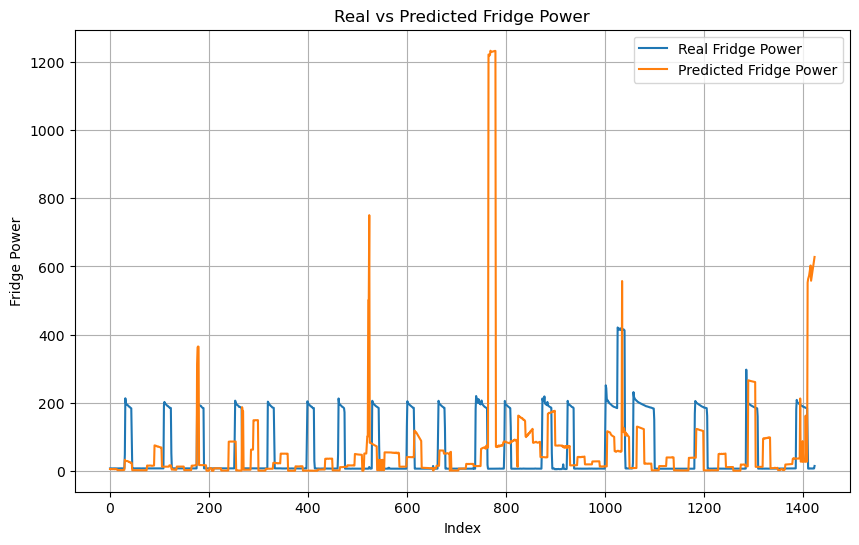

In [28]:
df_1 = pd.concat(pred_df_list, ignore_index=True)

# Assuming all_pred_df is defined elsewhere and contains the predicted values
all_pred_df = df_1.copy()  # Placeholder, replace with actual predicted values DataFrame

for app in appliance:
    # Extract real and predicted fridge power
    real_app_power = result_df[app].values
    predicted_app_power = all_pred_df[app].values

    print(len(real_app_power))
    print('PREDICTED',len(predicted_app_power))
    # Plot results and calculate MSE
    plot_results(real_app_power, predicted_app_power)
